In [1]:
import os
import glob

#For Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

#For checking progress
from tqdm import tqdm_notebook

import datetime
import time

#PyTorch Packages
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
##Estudando os dados....

#OpenCV-Python is a library of Python bindings designed to solve computer vision problems. 
#cv2.cvtColor() method is used to convert an image from one color space to another. There are more than 150
#color-space conversion methods available in OpenCV. We will use some of color space conversion codes below.

def get_image(path, transform=False):
    img = cv2.imread(path) # Use the function cv2.imread() to read an image.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert image from a color space to other.
    
    if transform:
        img = transform(img)
    
    return img


def show(rows, cols, is_train=True, transform=False):
    if is_train:
        path = './archive/dataset/dataset/train'
    else:
        path = './archive/dataset/dataset/test'
    
    path = os.path.join(path, '*', '*.png') # /home/jp/Desktop/archive/dataset/dataset/train/*/*.png
    
    print('path: {}'.format(path))
    img_paths = glob.glob(path)  # Return a possibly-empty list of path names that match pathname, 

    img_paths = np.random.choice(img_paths,rows*cols) #get random paths
    
    fig = plt.figure(figsize=(8,8),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_path = img_paths[i-1]
            if 'fresh' in image_path.split('/')[-2]:
                title = 'Fresh'
            else:
                title = 'Rotten'
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_path,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    return fig

path: /home/jp/Desktop/archive/dataset/dataset/test/*/*.png


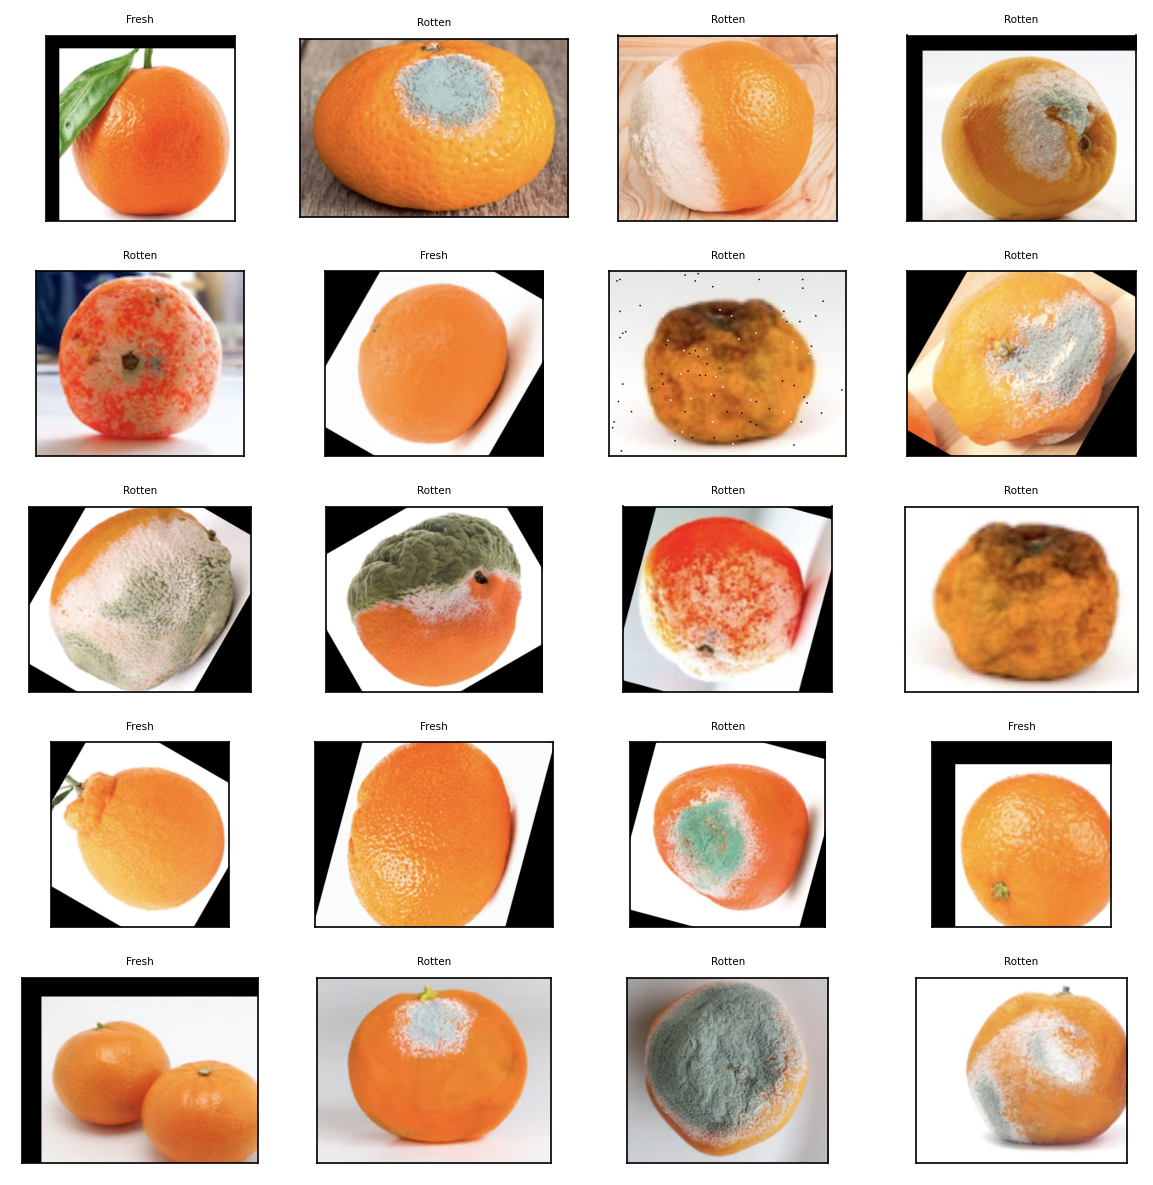

In [3]:
#test data
fig = show(5,4, False)
fig.tight_layout()

#train data
#fig = show(5,4, True)
#fig.tight_layout()

In [4]:
#from torch.utils.data.dataset import Dataset
#torch.utils.data.Dataset is an abstract class representing a dataset. The custom dataset should inherit Dataset
class FruitsDataset(Dataset):
    
    def __init__(self, path, classifier_type='Rotten', subset='train', transforms=None):
        
        self.subset=subset
        
        if self.subset == 'train':
            self.PATH = os.path.join(path, 'train', '*', '*.png')
        elif self.subset == 'test':
            self.PATH = os.path.join(path, 'test', '*', '*.png')
        
        self.data   = glob.glob(self.PATH)
        self.heigth = 32
        self.width  = 32
        self.labels = []
        
        if classifier_type == 'Rotten':
            classes = ['fresh', 'rotten']
            
            for fruit in self.data:
                if classes[0] in fruit.split('/')[-2]:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        
        self.transforms = transforms
    
    def __getitem__(self, index):
        
        img_path = self.data[index]
        img   = cv2.imread(img_path)
        img   = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img   = cv2.resize(img, (self.width, self.heigth))
        label = self.labels[index]
        
        if self.transforms is not None:
            img_as_tensor = self.transforms(img) #convert image to tensor.                
            return(img_as_tensor,label)
        
        else:
             return(img,label)
            
    def __len__(self):
        return(len(self.data))

In [5]:
#Pré-processamento

#Um problema que podemos enfrentar é que as amostras não são do mesmo tamanho.
#A maioria das redes neurais espera imagens de tamanho fixo, portanto vamos
#escrever algum código de pre-processamento.

#toTensor -> converte as imagens numpy em imagens torch.
#normalize -> para que imagens tenham uma media zero e variancia.
#Ja foi utilizadn o cv2 para deixar as imagens do mesmo tamanho.

transformations = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7321, 0.6322, 0.5291),
                                                           (0.3302, 0.3432, 0.3701))
                                      ])
dataset = FruitsDataset('./archive/dataset/dataset/',transforms = transformations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


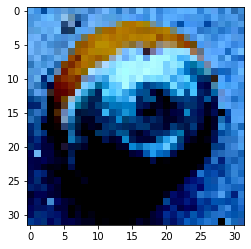

In [6]:
#Vamos dar uma olhada em uma imagem aleatoria.

img_t, _ = dataset[1000]
img = img_t.permute(1,2,0)
plt.imshow(img);

In [7]:
#Podemos iterar o dataset usando apenas um loop for simples,
#porem iremos usar a classse DataLoaders que ja abstrai varias coisas como processamento batch e etc...

batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print('Dataset size: {}'.format(dataset_size))
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

Dataset size: 3061


In [8]:
#Treinando o modelo
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [2]:
#Cpu vs GPU
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [10]:
def training_loop(n_epochs,optimizer,model,loss_fn,train_loader):
    for epoch in tqdm_notebook(range(1,n_epochs+1)):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            #get rid of gradients from last round
            optimizer.zero_grad()
            #performs backward step. Computes all the gradients
            loss.backward()
            #Updates the model
            optimizer.step()
            loss_train += loss.item()
        print('{} Epoch {}, Training Loop {}'.format(
          datetime.datetime.now(), epoch, loss_train/len(train_loader)))

model = Net().to(device=device) #was talking about this above
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
start_time = time.time()
training_loop(
  n_epochs = 25,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)
print("--- %s seconds ---" % (time.time() - start_time))


2020-10-12 19:22:25.771130 Epoch 1, Training Loop 0.6728877348777575
2020-10-12 19:22:32.269817 Epoch 2, Training Loop 0.6004297870856065
2020-10-12 19:22:38.810316 Epoch 3, Training Loop 0.4823362070780534
2020-10-12 19:22:45.667029 Epoch 4, Training Loop 0.39029429661921966
2020-10-12 19:22:52.370832 Epoch 5, Training Loop 0.3433929830789566
2020-10-12 19:22:59.107747 Epoch 6, Training Loop 0.32359624405701953
2020-10-12 19:23:05.919276 Epoch 7, Training Loop 0.3109925916561714
2020-10-12 19:23:13.617676 Epoch 8, Training Loop 0.2948952535024056
2020-10-12 19:23:21.778937 Epoch 9, Training Loop 0.2875643865420268
2020-10-12 19:23:28.768921 Epoch 10, Training Loop 0.28747537884956753
2020-10-12 19:23:35.632456 Epoch 11, Training Loop 0.27664941129011983
2020-10-12 19:23:42.584135 Epoch 12, Training Loop 0.27273412087024784
2020-10-12 19:23:49.586304 Epoch 13, Training Loop 0.2716895819474489
2020-10-12 19:23:56.236913 Epoch 14, Training Loop 0.26443452244767773
2020-10-12 19:24:02.769

In [12]:
# Treinamento utilizando pytorch 25 epocas: --- 175.96667766571045 seconds ---
# Média: 7 segundos por epoca.
# Dataset: 3061 imagens
# Treino (1500 laranjas ruins / 800 boas)
# Memoria maxima durante treinamento 4.0GB
# Memoria maxima GPU 763 MB

#Salvando modelo serializado
torch.save(model.state_dict(), 'ClassificadorDeLaranja.pt')

In [32]:
def validate(model,train_loader,val_loader):
    for name, loader in [('train',train_loader),('val',validation_loader)]:
        correct = 0
        total = 0

        #gradients nor required, as we don't want to train our parameters
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                #max_index,value
                _,predicted = torch.max(outputs,dim=1)
                total+=labels.shape[0]
                correct+=int((predicted==labels).sum())
    
        print('Accuracy {}: {:.2f}'.format(name, correct/total))

validate(model,train_loader,validation_loader)

Accuracy train: 0.91
Accuracy val: 0.93


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: 1
Prediction: tensor([[-3.0647,  2.4191]], device='cuda:0', grad_fn=<AddmmBackward>)


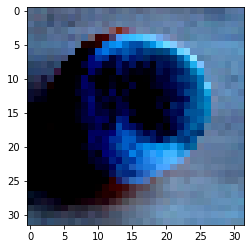

In [14]:
img,label = dataset[1]
plt.imshow(img.permute(1,2,0))
out = model(img.unsqueeze(0).to(device))
print('Actual: {}'.format(label))
print('Prediction: {}'.format(out))

In [33]:
correct = 0
total = 0
count = 0
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    out = model(imgs)
    _,predicted = torch.max(out,dim=1)
    correct += int((predicted==labels).sum())
    total += len(labels)
    count = count + 1


In [24]:
(correct/total)*100


91.05757452021234

In [34]:
transformations_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7369, 0.6360, 0.5318),
                                                           (0.3281, 0.3417, 0.3704))
                                      ])
test = FruitsDataset('/home/jp/Desktop/archive/dataset/dataset/',subset='test',transforms=transformations_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: tensor([[0.0058, 0.9942]], device='cuda:0', grad_fn=<SoftmaxBackward>)


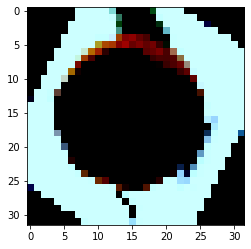

In [40]:
img,_ = test[400]
plt.imshow(img.permute(1,2,0))
s = nn.Softmax(dim=1)
out = s(model(img.unsqueeze(0).to(device)))
print('Prediction: {}'.format(out))

In [41]:
correct = 0
total = 0
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    out = model(imgs)
    _,predicted = torch.max(out,dim=1)
    correct += int((predicted==labels).sum())
    total += len(labels)

In [39]:
(correct/total)*100


91.05757452021234